In [5]:
from ipyparallel import Client
import os

rc = Client()
data_path = os.path.abspath("data")
res_path = os.path.abspath("results")

rc[:].push(dict(
    data_path=data_path,
    res_path=res_path,
))

dview = rc.load_balanced_view()

#dview = rc.direct_view('all')
print 'n of workers:', len(dview)
print len(rc)

n of workers: 4
4


In [6]:
print dview.queue_status()

{0: {'queue': 0, 'completed': 1, 'tasks': 0}, 1: {'queue': 0, 'completed': 1, 'tasks': 0}, 2: {'queue': 0, 'completed': 1, 'tasks': 0}, 3: {'queue': 0, 'completed': 1, 'tasks': 0}, 'unassigned': 0}


In [7]:
%%px --local
import pandas as pd
from string import strip
from goatools.base import download_go_basic_obo
from goatools.associations import read_associations
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.obo_parser import GODag
import scipy.cluster.hierarchy as sch
import numpy as np
from string import strip


In [ ]:
in_go=data_path+'/go-basic.obo'
in_assoc=data_path+'/associations.txt'
gene_found = [strip(n.split('\t')[0]) for n in open(data_path+'/in_df.txt').read().split('\n')]
obodag = GODag(in_go)
geneid2gos = read_associations(in_assoc)
goeaobj = GOEnrichmentStudy(
            gene_found, # List of mouse protein-coding genes
            geneid2gos, # geneid/GO associations
            obodag, # Ontologies
            propagate_counts = False,
            alpha = 0.05, # default significance cut-off
            methods = ['fdr_bh'])

In [ ]:
def score(in_genes, index_res, cut_distance, cluster_id):
    def count(goea_results_sig):
            res = {'BP' : 0,
                   'CC' : 0,
                   'MF' : 0}
            for item in goea_results_sig:
                item_list = str(item).split()            
                go_type = item_list[1] 
                res[go_type]+=1
            return res   
    goea_results_all = goeaobj.run_study(in_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    res = count(goea_results_sig)
    if sum(res.values())>0:
        res_file = open(res_path+'/'+'res_'+str(cut_distance)+'_'+str(cluster_id)+'.txt','w')
        res_file.write('\t'.join(['cut_distance','cluster_id','CC','MF','BP'])+'\n')
        res_file.write('\t'.join( [str(n) for n in [cut_distance,cluster_id,res['CC'],res['MF'],res['BP']]] ))
        res_file.close()
    #return count(goea_results_sig)

In [ ]:
def test():
    geneids_study = [strip(n) for n in open('test/protein_complexes/T_complex.txt').read().split('\n')]
    score(geneids_study, 'test_local', 0.04, 2)
    rc[1].apply(score, geneids_study, 'test_cluster', 0.05, 3)
#test()

In [ ]:
clustering_df = pd.DataFrame.from_csv('res_clustering.csv')
print clustering_df.shape
#print clustering_df.head()

In [ ]:
import time
import sys
start_time = time.time()
#res = []

for index, col in enumerate(clustering_df.columns):
    in_data = clustering_df[col].value_counts()
    in_data = in_data[in_data>=2]
    cut_distance = col.split('_')[-1]
    print index, col, cut_distance
    for cluster in in_data.index.values:
        genes = clustering_df[col][clustering_df[col]==cluster]
        genes = genes.index.values
        #print cluster, len(genes)
        #print 'send', index, cut_distance, cluster, 'to controller'
        dview.apply(score, genes, index, cut_distance, cluster)
        test = 0
        a=0
        while 1:
            #send more job only if the queue is less than 100
            #help to do not run out of memory
            if dview.queue_status()['unassigned']<100:            
                break
            else:
                a+=1
                #print a, 'unassigned:', dview.queue_status()['unassigned']
                #print 'waited for ', a*1, 'sec'
                sys.stdout.flush()
                time.sleep(1)            
                pass        


        
print 'end after : ', time.time() - start_time

In [21]:

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [16]:
list_df = [pd.read_table(res_path+'/'+path,sep='\t') for path in os.listdir(res_path)]
list_df = pd.concat(list_df)
list_df.sort_values(by='cut_distance', ascending=True, inplace=True)
print list_df.head()

   cut_distance  cluster_id  CC  MF  BP
0          0.09        2270   0   1   0
0          0.10        2268   0   1   0
0          0.10        1724   1   1   0
0          0.11        1724   1   1   0
0          0.11        2266   0   1   0


In [19]:
combined = list_df.groupby('cut_distance').sum()
del combined['cluster_id']
print combined.head()

              CC  MF  BP
cut_distance            
0.09           0   1   0
0.10           1   2   0
0.11           1   2   0
0.12           2   3   2
0.13           4   5   2


In [71]:


#combined_norm = combined[['CC','MF','BP']]
combined_norm = combined[['MF','BP']]
#print combined_norm.head()
for col in combined_norm.columns:
    combined_norm[col]=combined_norm[col]/combined_norm[col].max()
#print combined_norm.head()
combined_norm['median']=combined_norm.median(1)
combined_norm['median'] = combined_norm['median']/combined_norm['median'].max()
combined_norm['lowess'] = lowess(combined_norm['median'], combined_norm.index.values, frac = 0.1, return_sorted = False)
print combined_norm.head()
#print np.argmax(combined_norm['median'])

                    MF        BP    median    lowess
cut_distance                                        
0.09          0.017241  0.000000  0.008713  0.007019
0.10          0.034483  0.000000  0.017427  0.019555
0.11          0.034483  0.000000  0.017427  0.032101
0.12          0.051724  0.042553  0.047646  0.044659
0.13          0.086207  0.042553  0.065072  0.057232


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0, 1.1)

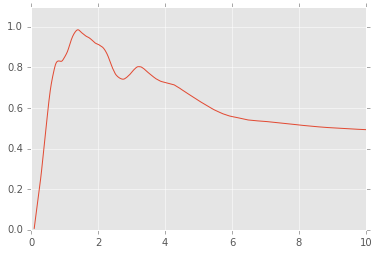

In [72]:

plt.plot(combined_norm['lowess'])
plt.xlim(0,10)
plt.ylim(0,1.1)

#plt.plot(combined_norm['MF'])
#plt.plot(combined_norm['BP'])
#fig, ax = plt.subplots(nrows=1,ncols=1)
